In [2]:
%matplotlib inline

In [3]:
import numpy
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import areposnap.gadget_snap

ELEMENTS = { 'H':0, 'He':1, 'C':2, 'N':3, 'O':4,
            'Ne':5, 'Mg':6, 'Si':7, 'Fe':8 }

# from Asplund et al. (2009) Table 5
SUNABUNDANCES = { 'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73,
                  'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54 }

In [4]:
def p2(a):
    return ((a)*(a))

In [5]:
def eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4],
                     haloid=0, galradfac=0.1, verbose=True):
    """ Method to eat an Auriga snapshot, given a level/halo_number/snapnr.
        Subfind has been executed 'on-the-fly', during the simulation run.

        @param level: level of the Auriga simulation (3=high, 4='normal' or 5=low).
            Level 3/5 only for halo 6, 16 and 24. See Grand+ 2017 for details.
            Careful when level != 4 because directories may have different names.
        @param halo_number: which Auriga galaxy? See Grand+ 2017 for details.
            Should be an integer in range(1, 31)
        @param snapnr: which snapshot number? This is an integer, in most cases
            in range(1, 128) depending on the number of timesteps of the run.
            The last snapshot would then be 127. Snapshots are written at a
            certain time, but careful because the variable called time is actually
            the cosmological expansion factor a = 1/(1+z). For example, snapnr=127
            has s.time = 1, which corresponds to a redshift of ~0. This makes sense
            because this is the last snapshot and the last snapshot is written at
            redshift zero
        @param snappath: full path to the level/halo directory that contains
            all of the simulation snapshots
        @param loadonlytype: which particle types should be loaded? This should
            be a list of integers. If I'm not mistaken, the options are:
            0 (gas), 1 (halo), 2 (disk), 3 (bulge), 4 (stars), 5 (black holes).
            So to get the dark matter: load particles 1/2/3. In zoom-simulations
            particletype 3 may be used for low-resolution particles in the outer
            regions and they should not be present in (and contaminating) the
            inner region. I'm not too sure of the latter though.
        @param haloid: the ID of the SubFind halo. In case you are interested
            in the main galaxy in the simulation run: set haloid to zero.
            This was a bit confusing to me at first because a zoom-simulation run
            of one Auriga galaxy is also referred to as 'halo', see halo_number.
        @param galradfac: the radius of the galaxy is often used to make cuts in
            the (star) particles. It seems that in general galrad is set to 10%
            of the virial radius R200 of the DM halo that the galaxy sits in. The
            disk does seem to 'end' at 0.1R200.
        @param verbose: boolean to print some information

        @return: two-tuple (s, sf) where s is an instance of the gadget_snapshot
            class, and sf is an instance of the subfind class. See Arepo-snap-util,
            gadget_snap.py respectively gadget_subfind.py """

    # Eat the subfind friend of friends output
    sf = load_subfind(snapnr, dir=snappath)

    # Eat the Gadget snapshot
    s = gadget_readsnap(snapnr, snappath=snappath, lazy_load=True,
        subfind=sf, loadonlytype=loadonlytype)
    s.subfind = sf

    # Sets s.(sub)halo. This allows selecting the halo, e.g. 0 (main 'Galaxy')
    s.calc_sf_indizes(s.subfind)
    # Note that selecting the halo now rotates the disk using the principal axis.
    # rotate_disk is a general switch which has to be set to True to rotate.
    # To then actually do the rotation, do_rotation has to be True as well.
    # Within rotate_disk there are three methods to handle the rotation. Choose
    # one of them, but see the select_halo method for details.
    s.select_halo( s.subfind, haloid=haloid, galradfac=galradfac,
        rotate_disk=True, use_principal_axis=True, euler_rotation=False,
        use_cold_gas_spin=False, do_rotation=True )

    # Sneak some more info into the s instance
    s.halo_number = halo_number
    s.level = level
    s.snapnr = snapnr
    s.haloid = haloid

    # This means that galrad is 10 % of R200 (200*rho_crit definition)
    s.galrad = galradfac * sf.data['frc2'][haloid]  # frc2 = Group_R_Crit200

    if verbose:
        print("\ngalrad  : {0}".format(s.galrad))
        print("redshift: {0}".format(s.redshift))
        print("time    : {0}".format(s.time))
        print("center  : {0}\n".format(s.center))

    return s, sf


In [6]:
def get_cartesian_vectors(s, sf, mask):
    x,  y,  z  = s.pos[::,2][mask], s.pos[::,1][mask], s.pos[::,0][mask]
    vx, vy, vz = s.vel[::,2][mask], s.vel[::,1][mask], s.vel[::,0][mask]

    # All three expressions for rxyz compute the same thing :-).
    # rxyz = numpy.sqrt( x**2 + y**2 + z**2)
    # rxyz = numpy.sqrt( (s.pos[mask]**2).sum(axis=1) )
    rxyz = s.r()[mask]

    # Both expressions for rxy compute the same thing :-).
    # rxy = numpy.sqrt( (s.pos[mask][:,1:]**2).sum(axis=1) )
    rxy = numpy.sqrt( x**2 + y**2 )

    return (x, y, z), (vx, vy, vz), rxyz, rxy


In [7]:
level = 4
basedir = "/Users/smilanov/Desktop/Auriga/level{0}/".format(level)
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127, 128, 1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))

        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath,
            loadonlytype=[1,2,3,4], haloid=0, galradfac=0.1, verbose=True)

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = numpy.maximum( s.data['gmet'], 1e-40 )

level   : 4
halo    : 24
snapnr  : 127
basedir : /Users/smilanov/Desktop/Auriga/level4/
halodir : /Users/smilanov/Desktop/Auriga/level4/halo_24/
snappath: /Users/smilanov/Desktop/Auriga/level4/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [14]:
com = s.getCenterOfMass()
angc = s.getAngularMomentumCore()

In [17]:
print(angc)

26073.6115926


Text(0,0.5,'z [kpc]')

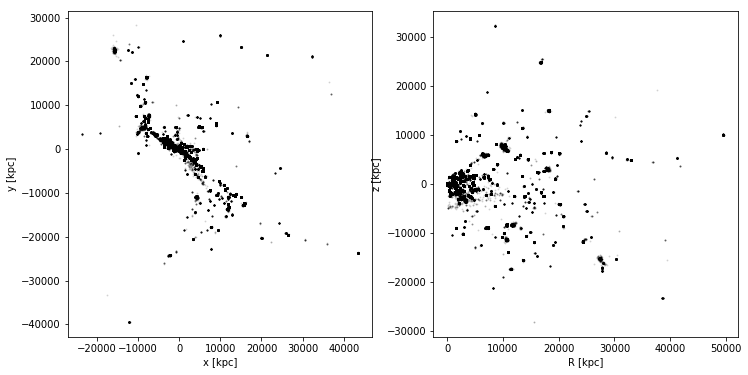

In [9]:
istars, = numpy.where( (s.type == 4) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))
ax1.plot(1000*x, 1000*y, "kD", ms=1, alpha=0.1)
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("y [kpc]")

ax2.plot(1000*rxy, 1000*z, "kD", ms=1, alpha=0.1)
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")

In [27]:
np.nonzero(sf.data['sprt'])

(array([    6,     7,     8,    11,    14,    18,    19,    20,    22,
           24,    25,    26,    37,    38,    46,    50,    51,    55,
           65,    71,    74,    79,    85,    87,    89,    90,    92,
           95,    96,    98,   101,   107,   112,   113,   114,   115,
          117,   119,   125,   126,   127,   134,   139,   144,   149,
          152,   154,   155,   159,   166,   173,   176,   179,   186,
          187,   188,   190,   192,   193,   196,   198,   199,   203,
          206,   208,   211,   214,   217,   219,   220,   231,   232,
          242,   243,   248,   249,   256,   258,   259,   261,   266,
          270,   276,   277,   278,   280,   298,   300,   301,   307,
          317,   320,   321,   324,   326,   332,   333,   334,   337,
          341,   342,   346,   349,   351,   352,   354,   355,   359,
          362,   363,   364,   371,   374,   378,   385,   386,   389,
          390,   391,   392,   405,   406,   408,   412,   413,   414,
      

In [11]:
print(s.id.shape)
print(imostbound.shape)
s.id == imostbound


(40242727,)
(20315,)


/Users/smilanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


False

IndexError: invalid index to scalar variable.

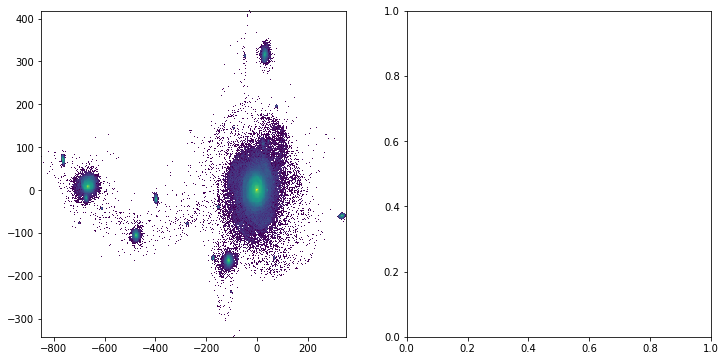

In [16]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)
#xt, yt, zt = x[im], y[im], z[im]
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))

ax1.hist2d(1000*x, 1000*y, bins=401, norm=matplotlib.colors.LogNorm())
#ax1.plot(sf.data["fpos"][iHalo0][:,1], sf.data["fpos"][iHalo0][:,2], "rX", ms=5)
#ax1.plot(xt, yt, 'rX')
ax1.plot(angc[2], angc[1], 'rX')
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.hist2d(1000*rxy, 1000*z, bins=401, norm=matplotlib.colors.LogNorm())
ax2.set_xlabel("R")
ax2.set_ylabel("z")




In [ ]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) & (s.r() > 10*s.galrad) )
# check if exclusion of central galaxy is necessary
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

import sklearn.cluster as cl
# n_cluster = 7 was better
X = numpy.vstack((x,y,z)).T
kmeans = cl.KMeans(n_clusters=9).fit(X)
centers = kmeans.cluster_centers_

In [ ]:
print(np.shape(centers))

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))

ax1.plot(x, y, "kD", ms=1, alpha=0.1, c = 'yellow')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.scatter(centers[ :, 0], centers[:,1], c = 'red', zorder = 5)
ax2.plot(x, z, "kD", ms=1, alpha=0.1)
ax2.scatter(centers[:,0],centers[:,2], c='red', zorder = 5)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

In [ ]:
hist, xedges, yedges = numpy.histogram2d(1000.*x[istars], 1000.*y[istars], bins = 100)
#maxval = numpy.max(hist)
maxindex = (-hist).argsort()
maxhist = (-hist).sort()

for i, item in enumerate(maxhist):
    ind = hist.index(item)
    targetval = 0.1*item
    outinds = np.where(hist < targetval)
    #foundinds = bisect()
    
    if i == 20: break
    